# Quantitative mutations using `qmut`
The package qmut contains mainly a class called QuantitativeMutation to enable the simulation of quantitative mutations of whole genome metabolic reconstructions. 

## Installation
 1. Check that you have `cobrapy` installed in your environment
 2. Download and copy the `\cobrapy_qmut` folder in your working directory.


## Turotial
In this tutorial we will show the main applications and methods of the QuantiativeMutation objects, briefly:


1. Load a metabolic model and create its QuantitativeMutation object
2. Using `Q.optimize()` and `Q.slim_optimize()` to find solutions and biomass production rate, respectively.
3. Generating random media following the protocol of [Shlomi et al.](https://pubmed.ncbi.nlm.nih.gov/17895423/) and applying it to `Q`.
4. Compute maximal bounds of `Q` across a list of media. And save/load them with `Q.load_bounds()` and `Q.save_bounds()`
5. Check how gene reaction rules are quantitatively interpreted.
6. Working with relative gene dosages and quantitative mutations.
7. Compute individuals, and populations in a single or in multiple processors.


### 0. First load some useful packages

In [1]:
import cobra
import cobrapy_qmut
import numpy as np
from matplotlib import pyplot as plt

### 1. Create qmut object and define standard medium and solver
We create an instance of QuantitativeMutation using a path to a model file in json format.

In [2]:
modelpath = './cobrapy_qmut/models/yeast_iND750.json'

Q = cobrapy_qmut.QuantitativeMutation('./cobrapy_qmut/models/yeast_iND750.json', verbose=True)

Academic license - for non-commercial use only - expires 2022-08-06
Using license file /home/pyubero/gurobi.lic
Loaded model iND750 from user file.
Biomass reaction id is BIOMASS_SC4_bal
The model has 750 genes and 1266 reactions.
... number of exchange reactions:	116
... number of non-exchange reactions:	1148


Check that `Q.model` can be accessed as a regular `cobra.Model`. For example, we can define the standard medium, and show the current solver used.

In [3]:
std_medium = {}
std_medium.update( {  'EX_o2_e'  : 2 } )
std_medium.update( {  'EX_co2_e' : 9999 } )
std_medium.update( {  'EX_k_e'   : 9999 } )
std_medium.update( {  'EX_na1_e' : 9999 } )
std_medium.update( {  'EX_nh4_e' : 9999 } )
std_medium.update( {  'EX_pi_e'  : 9999 } )
std_medium.update( {  'EX_so4_e' : 9999 } )
std_medium.update( {  'EX_h2o_e' : 9999 } )
std_medium.update( {  'EX_glc__D_e' : 20 } )

Q.model.medium = std_medium
Q.model.solver = 'glpk'

print('Solver being used: ', type(Q.model.solver))
print('')
print('Standard medium composition:')
_ = [ print('%13s\t%1.1f' % (key, value)) for key, value in Q.model.medium.items() ]

Solver being used:  <class 'optlang.glpk_interface.Model'>

Standard medium composition:
     EX_na1_e	9999.0
     EX_nh4_e	9999.0
      EX_o2_e	2.0
      EX_pi_e	9999.0
     EX_so4_e	9999.0
     EX_co2_e	9999.0
  EX_glc__D_e	20.0
     EX_h2o_e	9999.0
       EX_k_e	9999.0


### 2. Optimizing the model
We can also compute the biomass production, or any other optimization problem we may have set in different ways.

- Both original methods from the `cobra.Model` object work exactly as expected.
    1. Through the `cobra.Model.optimize()` method
    2. Through `cobra.Model.slim_optimize()` 


- Directly as `Q` methods
    3. Through Q's own `Q.optimize()`, work exactly as `Q.model.optimize()` for now...
    4. Through `Q.slim_optimize()`, which always returns the biomass production rate.

<> Although both return the same object, `Q`'s own method applies the current gene dosages within a model context manager. By now, there is no difference between both methods but only because our Q instance is unbounded, just as Q.model.

In [4]:
solution1 = Q.optimize()
solution2 = Q.model.optimize()
mu1 = Q.slim_optimize()
mu2 = Q.model.slim_optimize()

print('Solution 1 objective value:  %1.6f' % solution1.objective_value )
print('Solution 2 objective value:  %1.6f' % solution2.objective_value )
print('Q.model    objective value:  %1.6f' % mu1 )
print("Q's biomass production rate: %1.6f" % mu2 )
print('')
print('Are the fluxes of both solutions equal? ', all(solution1.fluxes==solution2.fluxes))

Solution 1 objective value:  0.513926
Solution 2 objective value:  0.513926
Q.model    objective value:  0.513926
Q's biomass production rate: 0.513926

Are the fluxes of both solutions equal?  True


However, `Q.slim_optimize()` will not always be faster

In [5]:
%timeit Q.model.slim_optimize()
%timeit Q.slim_optimize()

%timeit Q.model.optimize()
%timeit Q.optimize()

1.55 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.58 ms ± 4.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.5 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.2 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 3. Generate random media 
The function `Q.random_medium()` generates a random medium dict following the protocol originally from [Wang and Zhang] but widely used by [others].

First define a minimal composition of all media.

However, generating a random media **DOES NOT** mean using it!

In [6]:
minimal_medium = {}        
minimal_medium.update( {'EX_o2_e' :     2 }) #... oxygen
minimal_medium.update( {'EX_h2o_e' : 9999 }) #... water
minimal_medium.update( {'EX_co2_e' : 9999 }) #... carbon dioxyde
minimal_medium.update( {'EX_nh4_e' : 9999 }) #... ammonia
minimal_medium.update( {'EX_pi_e'  : 9999 }) #... phosphate
minimal_medium.update( {'EX_so4_e' : 9999 }) #... sulphate
minimal_medium.update( {'EX_k_e'   : 9999 }) #... potassium
minimal_medium.update( {'EX_na1_e' : 9999 }) #... sodium

rand_med = Q.random_medium(m = 0.1, minimal=minimal_medium, lower_lim=0, upper_lim = 20, method='linear')
print('Random medium composition:')
_ = [ print('%13s\t%1.3f' % (key, value)) for key, value in rand_med.items() ]

print('\nIs this random composition the same used in Q.model? ', rand_med == Q.model.medium )

Random medium composition:
     EX_pap_e	1.392
  EX_rib__D_e	13.664
  EX_sbt__D_e	1.116
   EX_thmmp_e	6.491
  EX_thr__L_e	5.063
   EX_ttdca_e	13.775
     EX_cit_e	1.088
    EX_dann_e	11.215
    EX_dcyt_e	14.384
     EX_din_e	16.331
     EX_fum_e	14.683
     EX_gal_e	10.480
  EX_ile__L_e	4.397
       EX_k_e	9999.000
   EX_8aonn_e	11.629
      EX_o2_e	2.000
     EX_h2o_e	9999.000
     EX_co2_e	9999.000
     EX_nh4_e	9999.000
      EX_pi_e	9999.000
     EX_so4_e	9999.000
     EX_na1_e	9999.000

Is this random composition the same used in Q.model?  False


### 3.1 Using context managers to temporally modify `Q.model`
You can use context managers as with `cobrapy` to temporally modify the model,e.g. the medium, and quickly test its viability.

In [7]:
with Q.model:
    Q.set_medium( rand_med )
    print('Biomass production in the random medium:   %1.4f' % Q.slim_optimize() )
print('Biomass production in the standard medium: %1.4f' % Q.slim_optimize() )

Biomass production in the random medium:   0.5357
Biomass production in the standard medium: 0.5139


Now we will create a list of 100 random media and measure the growth rate in all of them.

In [8]:
from tqdm import tqdm 

NMEDIA = 100

mu           = np.zeros((NMEDIA,))
random_media =[[],]*NMEDIA

for jj in tqdm(range(NMEDIA)):
    with Q.model:
        new_medium       = Q.set_medium( Q.random_medium( m = 0.10, minimal = minimal_medium) )
        mu[jj]           = Q.slim_optimize()
        random_media[jj] = new_medium
    
print('Finished computing.')

100%|██████████| 100/100 [00:05<00:00, 16.97it/s]

Finished computing.


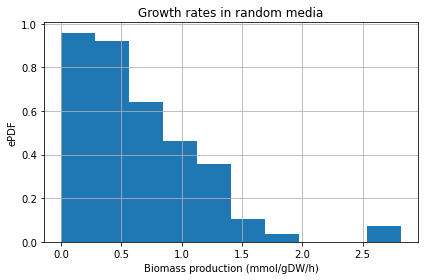

In [9]:
plt.figure( figsize=(6,4) )
plt.hist(mu, density=True);
plt.xlabel('Biomass production (mmol/gDW/h)')
plt.ylabel('ePDF')
plt.title('Growth rates in random media')
plt.grid();
plt.tight_layout();

### 4. Compute maximal bounds (lower and upper) in the standard medium and across random media





In [10]:
NSAMPLES       = 1_000 # 1000 samples in 50 processores takes about 25s each
MEDIA_RICHNESS = 0.10  # media richness scales with the number of components with which the minimal media is suplemented

# Initialize empty outputs
bounds_std = np.nan*np.zeros( (2,Q.N_NEX_RXNS) )
bounds_rnd = np.nan*np.zeros( (2,Q.N_NEX_RXNS) )

# Generate NSAMPLES random media
random_media_list   = [ Q.random_medium( m = MEDIA_RICHNESS, minimal = minimal_medium) for _ in range(NSAMPLES) ]
standard_media_list = [ std_medium for _ in range(NSAMPLES) ]

# Compute bounds in standard medium
Q.compute_bounds(media_list  = standard_media_list, 
                 pfba        = True, 
                 nprocessors = 50, 
                 chunksize   = 20 )


# Extract bounds found in standard medium
bounds_std[0,:] = [Q.upper_bounds[rxn_id] for rxn_id in Q.NEX_RXNS]
bounds_std[1,:] = [Q.lower_bounds[rxn_id] for rxn_id in Q.NEX_RXNS]



# Compute bounds in random medium
Q.compute_bounds(media_list  = random_media_list, 
                 pfba        = True, 
                 nprocessors = 50, 
                 chunksize   = 20 )

# Extract bounds found in random media
bounds_rnd[0,:] = [Q.upper_bounds[rxn_id] for rxn_id in Q.NEX_RXNS]
bounds_rnd[1,:] = [Q.lower_bounds[rxn_id] for rxn_id in Q.NEX_RXNS]

100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


If we compare the bounds obtained in standard vs random media, we find that the ones obtained in random med. tend to be larger than those obtained in standard med. The exceptions we find are 
- not great deviations from the diagonal, and 
- probably a problem due to using a small number of samples. 

For serious computations please use at least $10^4$ samples.

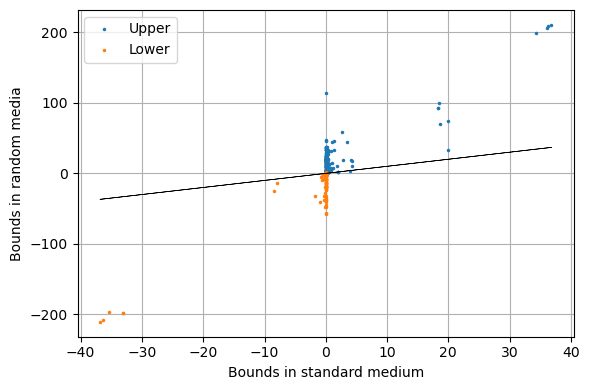

In [11]:
plt.figure( figsize=(6,4) , dpi=100)

plt.plot( bounds_std[0,:], bounds_rnd[0,:],'.', ms=3)
plt.plot( bounds_std[1,:], bounds_rnd[1,:],'.', ms=3)
plt.plot( bounds_std[0,:], bounds_std[0,:],'k', lw=0.5)
plt.plot( bounds_std[1,:], bounds_std[1,:],'k', lw=0.5)
plt.grid()
plt.xlabel('Bounds in standard medium')
plt.ylabel('Bounds in random media')
plt.legend(('Upper','Lower'))

plt.tight_layout();

You can save the bounds with an explicit description as a .txt file using `Q.save_bounds()`...

In [12]:
Q.save_bounds('bounds_test.txt', description='This is only a toy file.')

Maxbounds exported as bounds_test.txt on 2022-02-16 18:27:21.771082.


... and then load them using `Q.load_bounds()`.

To check that they were loaded correctly, compare the bounds of a reaction before and after loading the .txt file.

In [13]:
reaction = 'ACLSm'
print('Upper bound of %s: %1.4f' % (reaction, Q.upper_bounds[reaction]) )
Q.upper_bounds[reaction] = np.random.rand()

print('Random value assigned: %1.4f' % Q.upper_bounds[reaction])

# Load bounds
out = Q.load_bounds('bounds_10.0.csv')

print('Value after loading bounds: %1.4f' % Q.upper_bounds[reaction])
print('')
print('Some description of the loaded file:')
print(out.split(';')[1])

Upper bound of ACLSm: 1.4712
Random value assigned: 0.6593
Maxbounds loaded from bounds_10.0.csv on 2022-02-16 18:27:21.782826.
Value after loading bounds: 11.2277

Some description of the loaded file:
nsamples=10000.


### 5. Observe the gene reaction rule translation in action
All quantitative interpretation of gene reaction rules are stored as lambda functions in the dictionary `Q.GRR`.

Here we show an example for a specific reaction.

In [14]:
reaction = 'CYOR_u6m'

print('The complete gene reaction rule of %s is:' % reaction)
print(Q.model.reactions.get_by_id(reaction)._gene_reaction_rule)

print('\nThe list of genes involved is:')
print('  %10s\t%5s\t%s' % ('Identifier', 'Name', 'Dosage'))
print('  %10s\t%5s\t%s' % ('----------', '----', '------'))
_=[print('  %10s\t%5s\t%1.3f' % (gene.id, gene.name, Q.gene_dosage[gene.id])) for gene in Q.model.reactions.get_by_id(reaction).genes]

print('\nBy introducing these gene dosages in the GRR,\n',
      '\bresults in a relative flux of the reaction: %1.3f' % Q.GRR[reaction](Q) )

The complete gene reaction rule of CYOR_u6m is:
YHR001W_A and YJL166W and YGR183C and YBL045C and YFR033C and YEL024W and Q0105 and YDR529C and YOR065W and YPR191W

The list of genes involved is:
  Identifier	 Name	Dosage
  ----------	 ----	------
     YBL045C	 COR1	1.000
       Q0105	  COB	1.000
     YFR033C	 QCR6	1.000
     YGR183C	 QCR9	1.000
     YDR529C	 QCR7	1.000
     YJL166W	 QCR8	1.000
   YHR001W_A	QCR10	1.000
     YOR065W	 CYT1	1.000
     YPR191W	 QCR2	1.000
     YEL024W	 RIP1	1.000

By introducing these gene dosages in the GRR,
 results in a relative flux of the reaction: 1.000


### 6. Working with relative gene dosages
In light of the previous data, lets try to modify the gene dosage of one of the genes involved in the reaction. As the previous reaction is only composed of "AND" statements, the relative flux of the reaction should be the minimum of the dosages of those genes.

When calling a GRR lambda function, we need as first argument the object itself, this is because in general, we will only access these functions from within the object itself.

In [15]:
Q.set_dosage('YPR191W', np.random.rand() )

print('Dosage of YPR191W: %1.3f' % Q.gene_dosage['YPR191W'])
print('\nBy introducing these gene dosages in the GRR,\n',
      '\bresults in a relative flux of the reaction: %1.3f' % Q.GRR[reaction](Q) )

Dosage of YPR191W: 0.562

By introducing these gene dosages in the GRR,
 results in a relative flux of the reaction: 0.562


To set up a random genotype, although you can call `Q.set_dosage()` and iterate through all genes in `Q.GENES` you can also use `Q.set_genotype()`.

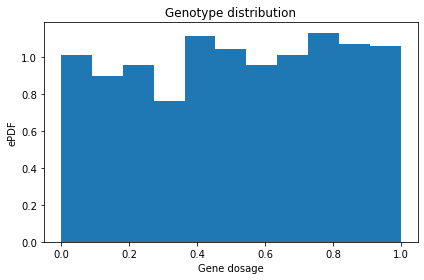

In [16]:
# Slow method:
#_ = [Q.set_dosage(gene, np.random.rand()) for gene in Q.GENES]

# Fast method:
Q.set_genotype( np.random.rand(Q.N_GENES) )

# Recover the genotype
g = [ value for key, value in Q.gene_dosage.items() ]

# Plot a histogram of gene dosages in the current individual
plt.figure( figsize=(6,4) )
plt.hist(g, bins=11, density=True)
plt.xlabel('Gene dosage')
plt.ylabel('ePDF')
plt.title('Genotype distribution')
plt.tight_layout();

**WARNING:** Gene dosages can be modified any time (in and out of context managers), however their effect will not take place until a call to `Q.apply_dosage()`, which changes the model reaction bounds. We strongly advise to use **ALWAYS** this within a context manager.

In [17]:
print('Biomass production before calling apply_dosage() : %1.4f' % Q.slim_optimize())

with Q.model:
    Q.apply_dosage()
    print('Biomass production after calling apply_dosage()  : %1.4f' % Q.slim_optimize())

print('Biomass production outside the context manager   : %1.4f' % Q.slim_optimize())


Biomass production before calling apply_dosage() : 0.5139
Biomass production after calling apply_dosage()  : 0.0257
Biomass production outside the context manager   : 0.5139


To restore the genotype, you can call `Q.reset_dosage()`:

In [18]:
print('Biomass production before calling apply_dosage() : %1.4f' % Q.slim_optimize())


Q.reset_dosage()
with Q.model:
    Q.apply_dosage()
    print('Biomass production after calling reset_dosage()  : %1.4f' % Q.slim_optimize())

print('Biomass production outside the context manager   : %1.4f' % Q.slim_optimize())


Biomass production before calling apply_dosage() : 0.5139
Biomass production after calling reset_dosage()  : 0.5139
Biomass production outside the context manager   : 0.5139


### You can use the functions in the `QuantitativeMutation` object to generate random genotypes, and set their clipping values

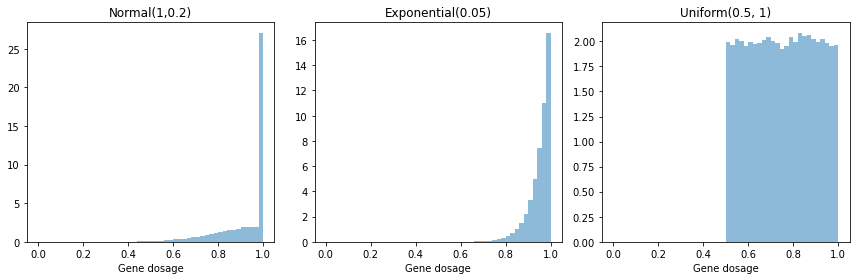

In [19]:
g1 = np.array([Q.random_genotype( sigma=[1,0.2], method='normal' )      for _ in range(100)])
g2 = np.array([Q.random_genotype( sigma=[0.05],  method='exponential' ) for _ in range(100)])
g3 = np.array([Q.random_genotype( sigma=[0.5,1], method='uniform' )     for _ in range(100)])
xx = np.linspace(0,1,51)


plt.figure( figsize=(12,4) )
plt.subplot(1,3,1)
plt.hist( g1.flatten() ,bins=xx, alpha=0.5, density=True)
plt.xlabel('Gene dosage')
plt.title('Normal(1,0.2)')

plt.subplot(1,3,2)
plt.hist( g2.flatten() ,bins=xx, alpha=0.5, density=True)
plt.xlabel('Gene dosage')
plt.title('Exponential(0.05)')

plt.subplot(1,3,3)
plt.hist( g3.flatten() ,bins=xx, alpha=0.5, density=True)
plt.xlabel('Gene dosage')
plt.title('Uniform(0.5, 1)')

plt.tight_layout();

### 7. Computing individuals and populations

Imagine that we would like to compute the biomass production of many random genotypes growing in the standard medium. 

#### 7.0 Computing individuals by "hand"

In [20]:
# Generate a random genotype
genotype = np.random.rand(Q.N_GENES)

with Q.model:
    # Set medium
    Q.model.medium = std_medium

    # Set genotype
    Q.set_genotype( genotype )

    # Apply dosage and compute solution
    Q.apply_dosage()
    print(Q.slim_optimize())


0.1951349383166596


#### 7.1 Computing individuals using `Q.compute_individual()`
For robustness, we enter a context manager and set the bounds.

In [21]:
with Q.model:
    # We call these for robustness
    Q.reset_dosage()
    Q.apply_dosage()
    
    # Compute individual
    _mu, _gen, _flx, _med, _wt = Q.compute_individual(genotype, std_medium)
print(_mu)

0.1951349383166597


#### 7.2 Computing a population "by hand"
and in standard medium

In [22]:
from datetime import datetime

NSAMPLES  = 10
genotypes = np.random.rand(NSAMPLES, Q.N_GENES)
media_list  = [ std_medium for _ in range(NSAMPLES) ]


tStart = datetime.now()
with Q.model:
    Q.reset_dosage()
    Q.apply_dosage()
    
    for jj in range(10):
        _mu, _gen, _flx, _med, _wt = Q.compute_individual( genotypes[jj,:] , media_list[jj] )
    
        
tTotal = (datetime.now()-tStart).total_seconds()
print('Running %d iterations have taken %1.1f seconds.' % (NSAMPLES, tTotal) )

Running 10 iterations have taken 1.9 seconds.


#### 7.2 Computing a population using `Q.compute_population()` in a parallel
and in standard medium

In [23]:
NPROCESSORS = 10

tStart = datetime.now()
with Q.model:
    Q.reset_dosage()
    Q.apply_dosage()
    
    _mu, _gen, _flx, _med, _wt = Q.compute_population( genotypes , media_list, nprocessors = NPROCESSORS)
    
      
tTotal = (datetime.now()-tStart).total_seconds()
print('Running %d iterations have taken %1.1f seconds.' % (NSAMPLES, tTotal) )

Computing population of 10 samples...


100%|██████████| 10/10 [00:00<00:00, 16.65it/s]

Total infeasible from within 0
Running 10 iterations have taken 0.9 seconds.
